# Short GRBS 

In [Ghirlanda et al. 2016](https://arxiv.org/abs/1607.07875) a fitting algorithm was used to determine the redshift and luminosity of short GRBS. We can use the parameters to reproduce the population and the observed GBM survey.

In [1]:
from popsynth import SFRDistribution, BPLDistribution, PopulationSynth, NormalAuxSampler, AuxiliarySampler, HardFluxSelection
from popsynth import update_logging_level
update_logging_level("INFO")

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context="notebook", fscale=1, grid=False)
purple = "#B833FF"
yellow = "#F6EF5B"

import networkx as nx
import numpy as np
import warnings

warnings.simplefilter("ignore")

In the work, the luminosity function of short GRBs is model as a broken power law.

In [3]:
bpl = BPLDistribution()

bpl.alpha = -0.53
bpl.beta = -3.4
bpl.Lmin = 1e47 # erg/s
bpl.Lbreak = 2.8e52
bpl.Lmax = 1e55


To model the redshift distribution, an empirical form from [Cole et al 2001](https://academic.oup.com/mnras/article/326/1/255/1026734?login=true) is used. In ```popsynth``` we call this the ```SFRDistribution``` (but perhaps a better name is needed).

In [4]:
sfr = SFRDistribution()

In [5]:
sfr.r0 = 5.
sfr.a = 1
sfr.rise = 2.8
sfr.decay = 3.5
sfr.peak = 2.3

We can checkout how the rate changes with redshift

Text(0, 0.5, '$\\frac{\\mathrm{d}N}{\\mathrm{d}V}$')

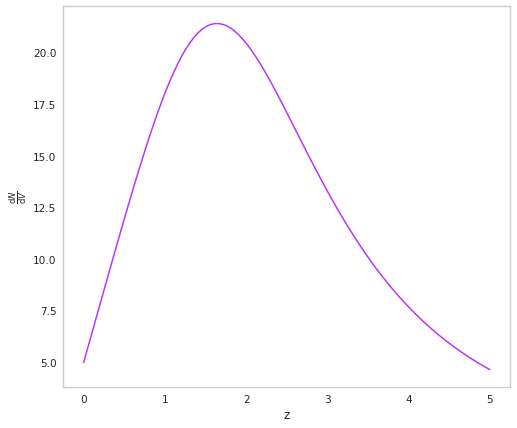

In [6]:
fig, ax = plt.subplots()

z = np.linspace(0,5,100)

ax.plot(z, sfr.dNdV(z), color=purple)
ax.set_xlabel("z")
ax.set_ylabel(r"$\frac{\mathrm{d}N}{\mathrm{d}V}$")

In their model, the authors also have some secondary parameters that are connected to the luminosity. These are the  parameters for the spectrum of the GRB. It is proposed that the spectra peak energy (Ep) is linked to the luminosity by a power law relation:


$$ \log E_{\mathrm{p}} \propto a + b \log L$$

We can build an auxiliary sample to simulate this as well. But we will also add a bit of scatter to the intercept of the relation.

In [7]:
intercept =NormalAuxSampler(name="intercept", observed=False)

intercept.mu = 0.034
intercept.sigma = .005




In [8]:
class EpSampler(AuxiliarySampler):
    
    _auxiliary_sampler_name = "EpSampler"

    def __init__(self):

        # pass up to the super class
        super(EpSampler, self).__init__("Ep", observed=True, uses_luminosity = True)

    def true_sampler(self, size):

        # we will get the intercept's latent (true) value
        # from its sampler
        
        intercept = self._secondary_samplers["intercept"].true_values
        
        slope = 0.84

        self._true_values = np.power(10., intercept + slope * np.log10(self._luminosity/1e52) + np.log10(670.))
        
    def observation_sampler(self, size):
        
        # we will also add some measurement error to Ep
        self._obs_values = self._true_values + np.random.normal(0., 10, size=size)
        

Now we can put it all together.

In [9]:
pop_synth = PopulationSynth(spatial_distribution=sfr, luminosity_distribution=bpl)

We will have a hard flux selection which is Fermi-GBM's fluz limit of ~ 1e-7 erg/s/cm2

In [10]:
selection = HardFluxSelection()
selection.boundary = 1e-7

In [11]:
pop_synth.set_flux_selection(selection)

We need to add the Ep sampler. Once we set the intercept sampler as a secondary it will automatically be added to the population synth.

In [12]:
ep = EpSampler()

In [13]:
ep.set_secondary_sampler(intercept)

In [14]:
pop_synth.add_auxiliary_sampler(ep)

 INFO     |  registering auxilary sampler: Ep 


We are ready to sample our population. We will add some measurement uncertainty to the fluxes as well.

In [15]:
population = pop_synth.draw_survey(flux_sigma=0.2)

 INFO     |  The volume integral is 797.550666 


Drawing distances:   0%|          | 0/770 [00:00<?, ?it/s]

 INFO     |  Expecting 770 total objects 


 INFO     |  Sampling: Ep 


 INFO     |  Ep is sampling its secondary quantities 


 INFO     |  Sampling: intercept 


 INFO     |  applying selection to fluxes 


 INFO     |  Detected 499 distances 


 INFO     |  Detected 499 objects out to a distance of 5.31 


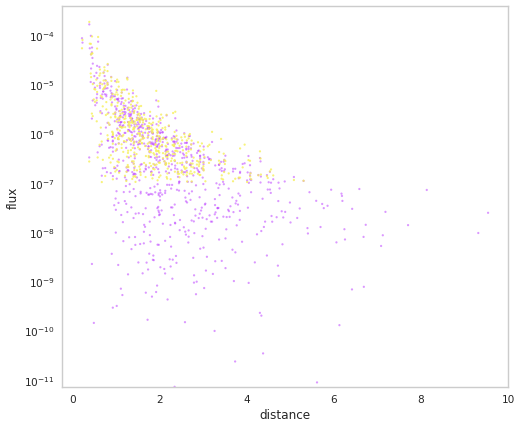

In [16]:
population.display_fluxes(true_color=purple, obs_color=yellow, with_arrows=False, s= 5);

Let's look at our distribution of Ep

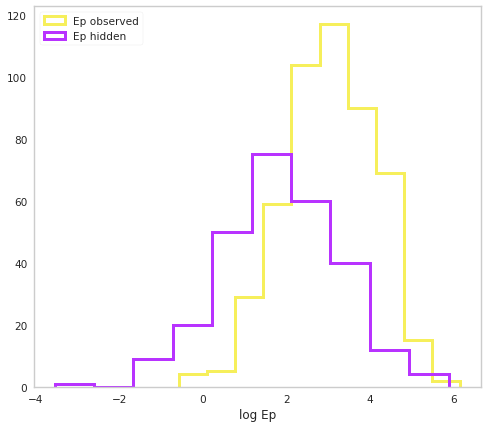

In [17]:
fig, ax = plt.subplots()

ax.hist(np.log10(population.Ep_obs[population.selection]), histtype="step", color=yellow, lw=3, label="Ep observed")
ax.hist(np.log10(population.Ep[~population.selection]), histtype="step", color=purple, lw=3,  label="Ep hidden")
ax.set_xlabel("log Ep")

ax.legend()

Text(0.5, 0, 'log Flux')

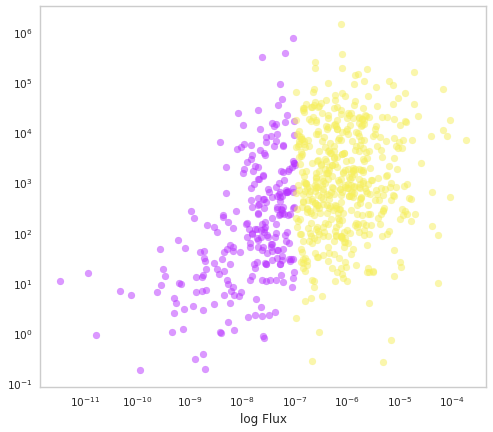

In [18]:
fig, ax = plt.subplots()


ax.scatter(population.fluxes_observed[~population.selection],
           population.Ep_obs[~population.selection],c=purple, alpha=0.5)
ax.scatter(population.fluxes_observed[population.selection],
           population.Ep_obs[population.selection],c=yellow, alpha=0.5)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("log Ep")
ax.set_xlabel("log Flux")

Does this look like the observed catalogs?